In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# Deep Neural Networks 
## Session 22

##  Pytorch Convolutional Neural Network (CNN)
### CIFAR10
- Save model
- Learning Rate Schedule
- Early Stopping



In [2]:
###-----------------
### Import Libraries
###-----------------

import os
import time
import numpy as np
import pandas as pd

# from tqdm import tqdm, trange

import torch
import torch.nn as nn
# import torch.nn.functional as F
# from torch.autograd import Variable
from torchvision import datasets, transforms
from torchsummary import summary

from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, accuracy_score

import matplotlib.pyplot as plt

from utils.helper import fn_plot_torch_hist

2025-11-19 16:42:00.870630: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
###----------------------
### Some basic parameters
###----------------------

# Directories
inpDir = '../../input' # location where input data is stored
outDir = '../output' # locatest_dataset.dataset.classestion to store outputs
subDir = 'cifar10' # location of the images
modelDir = '../models' # location to save model files
altName = 'torch_bn_do_leaky' # Model file name for this alternative

RANDOM_STATE = 24 # for initialization ----- REMEMBER: to remove at the time of promotion to production

# Number of cycles to run
EPOCHS = 100

# How many training examples to consider in one batch
BATCH_SIZE = 32 

# image size for analysis
IMG_HEIGHT = 32
IMG_WIDTH = 32 

# patience before early stipping
PATIENCE = 20

# patience and factor for learning rate
LR_PATIENCE = 10
LR_FACTOR = 0.1

# Learning Rate
ALPHA = 0.001

# minimum difference
EPSILON = 1e-8

# Set parameters for decoration of plots
params = {'legend.fontsize' : 'large',
          'figure.figsize'  : (15,8),
          'axes.labelsize'  : 'x-large',
          'axes.titlesize'  :'x-large',
          'xtick.labelsize' :'large',
          'ytick.labelsize' :'large',
         }

CMAP = plt.cm.coolwarm

plt.rcParams.update(params) # update rcParams


# Path to final model and best weights
bestModelDict = os.path.join(modelDir, subDir, f'best_{altName}_param_dict')

bestModelPath =  os.path.join(modelDir, subDir, f'best_{altName}.pth')

## All about CUDA

In [4]:
print ('Is CUDA available: ', torch.cuda.is_available())

print ('CUDA version: ', torch.version.cuda )

print ('Current Device ID: ', torch.cuda.current_device())

print ('Name of the CUDA device: ', torch.cuda.get_device_name(torch.cuda.current_device()))

# Get cpu or gpu device for training.

device = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Using {device} device")

Is CUDA available:  True
CUDA version:  12.8
Current Device ID:  0
Name of the CUDA device:  NVIDIA GeForce RTX 3060 Laptop GPU
Using cuda device


## Helper Functions

In [5]:
# Function to display images imported through pytorch.

def fn_imshow(image, ax=None, title=None, normalize=True):
    
    '''
    Args:
        image: image with channel first and floats
        ax : Matplotlib axis,
        title: titile of the image
        normalize: If there is need to normalize the image
        
    Return: Matplotlib axis
    
    '''
    
    # if there is no axis, create one
    if ax is None:
        fig, ax = plt.subplots()
        
    # convert channel first to channel last
    image = image.numpy().transpose((1, 2, 0))

    # Do we want to normalize the image
    if normalize:
        
        mean = np.array([0.485, 0.456, 0.406])
        
        std = np.array([0.229, 0.224, 0.225])
        
        image = std * image + mean
        
        image = np.clip(image, 0, 1)
        
    # Show image on the axis
    ax.imshow(image)
    
    # Show classname on the image
    ax.set_title(title)
    
    # switch off all spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    
    # No tick labels
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax

### Transforms

Normalize a tensor image with mean and standard deviation. Given mean: (mean[1],...,mean[n]) and std: (std[1],..,std[n]) for n channels, this transform will normalize each channel of the input torch.*Tensor i.e., output[channel] = (input[channel] - mean[channel]) / std[channel]
Parameters:

        mean (sequence) – Sequence of means for each channel.

        std (sequence) – Sequence of standard deviations for each channel.

        inplace (bool,optional) – Bool to make this operation in-place.



In [6]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize ( mean=[0.485, 0.456, 0.406], 
                           std=[0.229, 0.224, 0.225])    
    ])

In [7]:
trainset = datasets.CIFAR10(root=inpDir, 
                            train=True,
                            download=True, 
                            transform=transform)


trainloader = torch.utils.data.DataLoader(trainset, 
                                          batch_size=BATCH_SIZE,
                                          shuffle=True, 
                                          num_workers=8)

testset = datasets.CIFAR10(root=inpDir, 
                                       train=False,
                                       download=True, 
                                       transform=transform)

testloader = torch.utils.data.DataLoader(testset, 
                                         batch_size=BATCH_SIZE,
                                         shuffle=False, 
                                         num_workers=8)

class_names = ['plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

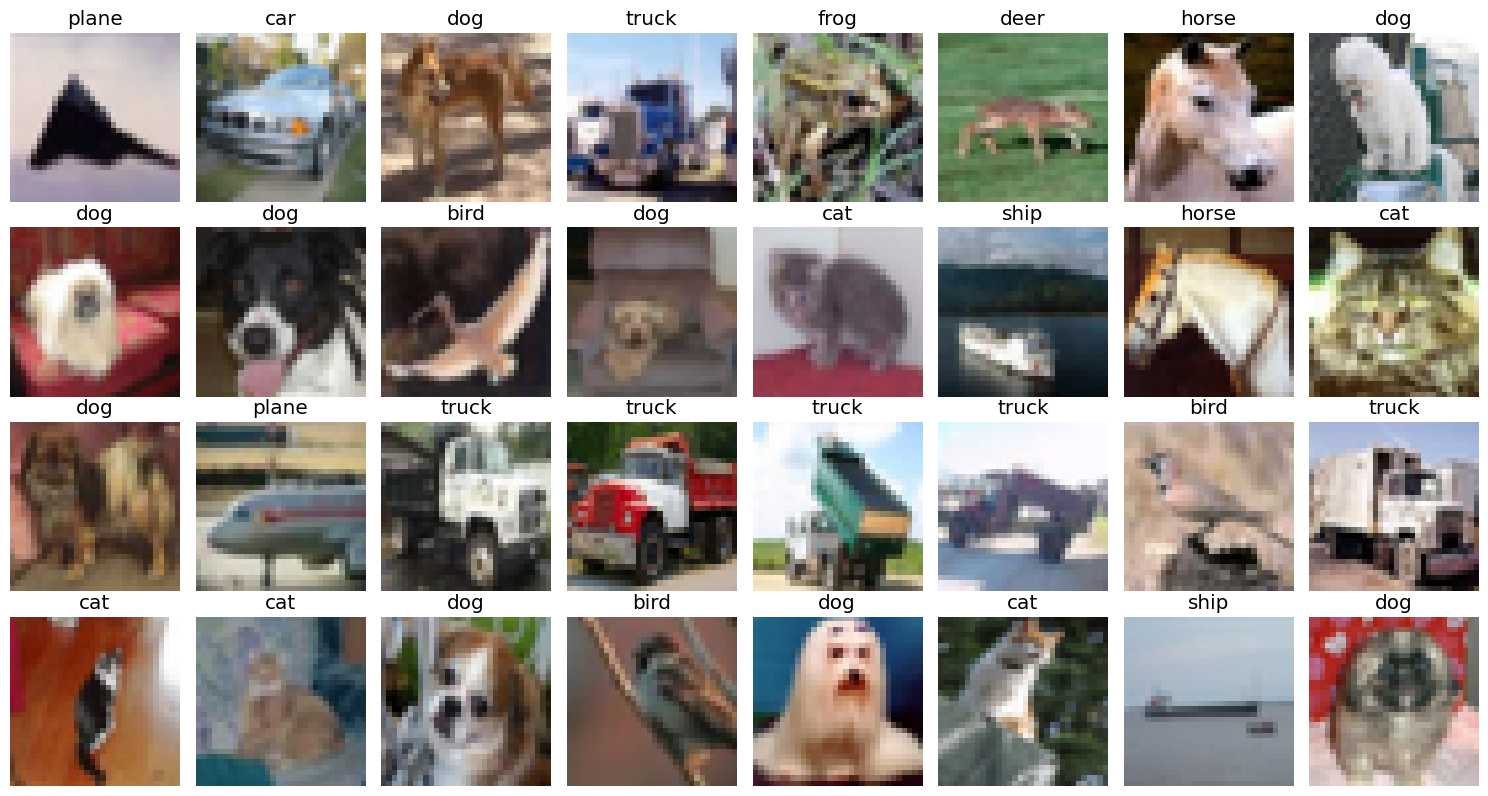

In [8]:
# Run this to test your data loader
images, labels = next(iter(trainloader))

# set figure size
fig = plt.figure(figsize = (15,8))  # figure size in inches with default params

# Adjust the subplot layout parameters.
fig.subplots_adjust(left=0., # as a fraction of the figure width
                    right=1., # use full width, as a fraction of the figure width
                    bottom=0., # as a fraction of the figure height
                    top=1., # as a fraction of the figure height
                    hspace=0.05, # as a fraction of the average Axes height
                    wspace=0.05) # width of the padding between subplots

for i in range (BATCH_SIZE):# loop over all images
    
    # add a subplot
    ax = fig.add_subplot( BATCH_SIZE//8, 8, (i+1), xticks=[], yticks=[]) # add a subplot tthe figure
    
    fn_imshow(images[i], ax = ax, normalize=True)
    
    # display class in the title
    ax.set_title(class_names[labels[i]])

plt.tight_layout()

In [9]:
# What is inside trainloader
trainloader.dataset

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ../../input
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [10]:
numChannels = 3

numClasses = len(class_names)

# calculate steps per epoch for training and validation set
trainSteps = len(trainloader.dataset) // BATCH_SIZE

testSteps = len(testloader.dataset) // BATCH_SIZE

## Define a model

Even for testing and loading saved model, we need to define the model. 

In [11]:
class LeNet(nn.Module):
    
    def __init__(self, numChannels, classes):
        
        # call the parent constructor
        super(LeNet, self).__init__()
        
        # Dropouts
        dor1 = 0.15 # drop out rates
        dor2 = 0.30 # drop out rates
        dor3 = 0.50 # drop out rates

        ###----------------
        ### Defining layers
        ###----------------
        
        
        #############
        ### Set 01 ##
        #############

        
        # Output filters
        out_channels1 = 32
        
        # CONV => Batch Norm => LEakyReLU => POOL layers => Dropout layer
        self.conv1 = nn.Conv2d (in_channels = numChannels, 
                                out_channels = out_channels1,
                                padding = 'same',
                                kernel_size=(3, 3))  #  output_shape = 32, 32, 32

        self.bn1 = nn.BatchNorm2d(out_channels1)
        
        self.actv1 = nn.LeakyReLU()
        
        self.maxpool1 = nn.MaxPool2d(kernel_size=(2, 2), 
                                     stride=(2, 2))   #  output_shape = 16 x 16 x 32
        
        self.dropout1 = nn.Dropout(p=dor1)

        #############
        ### Set 02 ##
        #############

        # Output filters
        out_channels2 = 64
        
        # CONV => Batch Norm => LEakyReLU => POOL layers => Dropout layer

        self.conv2 = nn.Conv2d ( in_channels = out_channels1,
                                out_channels = out_channels2,
                                padding = 'same',
                                kernel_size = (3, 3) )   #  output_shape = 16 x 16 x 64
        
        self.bn2 = nn.BatchNorm2d(out_channels2)
        
        self.actv2 = nn.LeakyReLU()
        
        self.maxpool2 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))   #  output_shape = 8, 8, 64
        
        self.dropout2 = nn.Dropout(p=dor1)
        
        #############
        ### Set 03 ##
        #############
        
        # Output filters
        out_channels3 = 128
        
        # CONV => Batch Norm => LEakyReLU => POOL layers => Dropout layer
        
        self.conv3 = nn.Conv2d ( in_channels = out_channels2,
                                out_channels = out_channels3,
                                kernel_size = (3, 3) )    #  output_shape = 6 x 6 x 128
        
        self.bn3 = nn.BatchNorm2d(out_channels3)
        
        self.actv3 = nn.LeakyReLU()
        
        self.maxpool3 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))    #  output_shape = 3 x 3 x 128
        
        self.dropout3 = nn.Dropout ( p = dor1 )
 
        #############
        ### Set 04 ##
        #############

        # Output filters
        out_channels4 = 256
        
        # CONV => Batch Norm => LeakyReLU => POOL layers => Dropout layer
        self.conv4 = nn.Conv2d ( in_channels = out_channels3,
                                out_channels = out_channels4,
                                kernel_size = (3, 3) )    #  output_shape =  1 x 1 x 256
        
        self.bn4 = nn.BatchNorm2d(out_channels4)
        
        self.actv4 = nn.LeakyReLU()
              
        out_channels5 = 128
        
        self.fc1 = nn.Linear( in_features = 1 * 1 * out_channels4 , out_features = out_channels5 )
        
        self.bn5 = nn.BatchNorm1d(out_channels5)
        
        self.actv5 = nn.LeakyReLU()
        
        self.dropout5 = nn.Dropout ( p = dor2 )
        
        # Final output layer
        self.fc2 = nn.Linear( in_features = out_channels5, out_features = classes )
        
        # initialize our softmax classifier
        self.logSoftmax = nn.LogSoftmax(dim=1)
        
        
    def forward(self, x):
        
        
        # pass the input through our first set
        x = self.conv1( x )
        x = self.bn1( x )
        x = self.actv1( x )
        x = self.maxpool1( x )
        x = self.dropout1( x )

        
        # pass the output from the previous layer through the second set
        x = self.conv2 ( x )
        x = self.bn2 ( x )
        x = self.actv2 ( x )
        x = self.maxpool2 ( x )
        x = self.dropout2 ( x )
        
        # pass the output from the previous layer through the third set
        x = self.conv3 ( x )
        x = self.bn3 ( x )
        x = self.actv3 ( x )
        x = self.maxpool3 ( x )
        x = self.dropout3 ( x )
        
        # pass the output from the previous layer through the fourth set
        x = self.conv4 ( x )
        x = self.bn4 ( x )
        x = self.actv4 ( x )

        # flatten the output from the previous layer and pass it
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.bn5 ( x )
        x = self.actv5(x)
        x = self.dropout5 ( x )
        
        # pass the output to our softmax classifier to get our output
        # predictions
        x = self.fc2(x)
        output = self.logSoftmax(x)
        
        # return the output predictions
        return output

In [12]:
# initialize the LeNet model
print("[INFO] Initializing the LeNet model...", end = ' ')
model = LeNet(numChannels = numChannels,
              classes = numClasses).to(device)

# initialize our optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=ALPHA)
# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                                     mode='min', 
                                                     factor=LR_FACTOR, 
                                                     patience=LR_PATIENCE,
                                                     min_lr=1e-5)

# loss function
#lossFn = nn.NLLLoss()
lossFn = nn.CrossEntropyLoss()



# initialize a dictionary to store training history
H = {'epoch' : [],
    'train_loss': [],
    'test_loss' : [],
    'train_acc' : [],
    'test_acc' : [],
    'alpha' : []
}
print ('done...')

[INFO] Initializing the LeNet model... done...


In [13]:
# What do we got...

_ = summary(model, (3, IMG_HEIGHT, IMG_WIDTH))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
       BatchNorm2d-2           [-1, 32, 32, 32]              64
         LeakyReLU-3           [-1, 32, 32, 32]               0
         MaxPool2d-4           [-1, 32, 16, 16]               0
           Dropout-5           [-1, 32, 16, 16]               0
            Conv2d-6           [-1, 64, 16, 16]          18,496
       BatchNorm2d-7           [-1, 64, 16, 16]             128
         LeakyReLU-8           [-1, 64, 16, 16]               0
         MaxPool2d-9             [-1, 64, 8, 8]               0
          Dropout-10             [-1, 64, 8, 8]               0
           Conv2d-11            [-1, 128, 6, 6]          73,856
      BatchNorm2d-12            [-1, 128, 6, 6]             256
        LeakyReLU-13            [-1, 128, 6, 6]               0
        MaxPool2d-14            [-1, 12

In [ ]:
# measure how long training is going to take
print("[INFO] Training the network...")
startTime = time.time()

# loop over our epochs
for e in range(EPOCHS):
    
    epochStart = time.time()
    
    # set the model in training mode
    model.train()
    
    # initialize the total training and validation loss
    totalTrainLoss = 0
    totalTestLoss = 0
    
    # initialize the number of correct predictions in the training
    # and validation step
    trainCorrect = 0
    testCorrect = 0
    
    
    # loop over the training set
    for (X_train, y_train) in trainloader:
        
        # send the input to the device
        X_train =  X_train.to ( device )
        y_train = y_train.to ( device )
        
        # perform a forward pass and calculate the training loss
        pred_train = model ( X_train )
        train_loss = lossFn ( pred_train, y_train )
        
        # zero out the gradients, perform the backpropagation step,
        # and update the weights
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()
        
        # add the loss to the total training loss so far and
        # calculate the number of correct predictions
        totalTrainLoss += train_loss
        trainCorrect += ( pred_train.argmax ( 1 ) == y_train ).type ( torch.float ).sum().item()
        
    # Now we can evaluate our model on the validation set:
    # switch off autograd for evaluation
    with torch.inference_mode():
        
        # set the model in evaluation mode
        model.eval()

        # loop over the validation set
        for ( X_test, y_test ) in testloader:
            
            # send the input to the device
            X_test = X_test.to ( device )
            y_test = y_test.to ( device )

            # make the predictions and calculate the validation loss
            pred_test = model ( X_test )
            totalTestLoss += lossFn ( pred_test, y_test )

            # calculate the number of correct predictions
            testCorrect += ( pred_test.argmax ( 1 ) == y_test ).type( torch.float ).sum().item()


        # Step the scheduler
        scheduler.step(totalTestLoss)


    # calculate the average training and validation loss
    avgTrainLoss = totalTrainLoss / trainSteps
    avgTestLoss = totalTestLoss / testSteps

    # calculate the training and validation accuracy
    trainCorrect = trainCorrect / len ( trainloader.dataset )
    testCorrect  = testCorrect / len ( testloader.dataset )

    # update our training history
    H["epoch"].append(e)
    H["train_loss"].append(avgTrainLoss.cpu().detach().numpy().item()) # output is tensor on gpu
    H["test_loss"].append(avgTestLoss.cpu().detach().numpy().item())
    H["train_acc"].append(trainCorrect)
    H["test_acc"].append(testCorrect)
    H["alpha"].append(scheduler.get_last_lr()[0]) # output is list

    if e%10 == 0:
        # print the model training and validation information
        print(f'[INFO] EPOCH: {e: 3d}/{EPOCHS} Loss: {avgTrainLoss:.6f} / {avgTestLoss:.6f} | Accuracy: {trainCorrect:.4f} / {testCorrect:.4f} in : {time.time() - epochStart:.2f} sec.')

# finish measuring how long training took
endTime = time.time()

print("[INFO] total time taken to train the model: {:.2f} min".format((endTime - startTime) / 60.))

[INFO] Training the network...
[INFO] EPOCH:   0/100 Loss: 1.286364 / 1.011200 | Accuracy: 0.5409 / 0.6463 in : 8.95 sec.
[INFO] EPOCH:   1/100 Loss: 0.968258 / 0.802083 | Accuracy: 0.6618 / 0.7203 in : 8.83 sec.
[INFO] EPOCH:   2/100 Loss: 0.847825 / 0.687702 | Accuracy: 0.7038 / 0.7617 in : 7.95 sec.
[INFO] EPOCH:   3/100 Loss: 0.762764 / 0.696348 | Accuracy: 0.7329 / 0.7604 in : 8.78 sec.
[INFO] EPOCH:   4/100 Loss: 0.703434 / 0.634511 | Accuracy: 0.7578 / 0.7780 in : 8.18 sec.
[INFO] EPOCH:   5/100 Loss: 0.648062 / 0.612611 | Accuracy: 0.7752 / 0.7903 in : 7.92 sec.
[INFO] EPOCH:   6/100 Loss: 0.615041 / 0.591315 | Accuracy: 0.7859 / 0.7962 in : 8.43 sec.
[INFO] EPOCH:   7/100 Loss: 0.574792 / 0.560530 | Accuracy: 0.8008 / 0.8086 in : 8.31 sec.
[INFO] EPOCH:   8/100 Loss: 0.538477 / 0.575150 | Accuracy: 0.8109 / 0.8026 in : 8.19 sec.
[INFO] EPOCH:   9/100 Loss: 0.513796 / 0.571611 | Accuracy: 0.8219 / 0.8063 in : 8.26 sec.
[INFO] EPOCH:  10/100 Loss: 0.492093 / 0.545641 | Accuracy:

In [ ]:
fn_plot_torch_hist(pd.DataFrame(H))

## Load Best Model

In [ ]:
model_dict = torch.load(bestModelDict)
model_dict.keys()

In [ ]:
model1 = LeNet(numChannels = numChannels,
              classes = numClasses).to(device)
model1.load_state_dict(model_dict['model_state_dict'])

In [ ]:
with torch.inference_mode():
    
    # set the model in evaluation mode
    model1.eval()

    # initialize a list to store our predictions
    preds = []
    labels = []
    # loop over the test set
    for (images, label) in testloader:
        
        # send the input to the device
        images = images.to(device)
        labels.extend(label.cpu().numpy())
        # make the predictions and add them to the list
        pred = model1(images)
        preds.extend(pred.argmax(axis=1).cpu().numpy())

In [ ]:
accuracy_score(np.array ( labels ), 
               np.array ( preds ))

In [ ]:
print(classification_report ( labels, preds, 
                             target_names = class_names ) )

In [ ]:
cm  = confusion_matrix(labels, preds)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

fig, ax = plt.subplots(figsize = (6,6))

disp.plot(ax = ax, cmap = 'Blues', colorbar=False, xticks_rotation=45)
plt.show();


In [ ]:
# Run this to test your data loader
images, labels = next(iter(testloader))

# Predict again to keep y_pred in synch with the images
images = images.to(device)
yhat = model1(images)

y_pred = yhat.argmax(axis = 1).cpu().detach().numpy()
labels = labels


# set figure size
fig = plt.figure(figsize = (15,8))  # figure size in inches with default params

# Adjust the subplot layout parameters.
fig.subplots_adjust(left=0., # as a fraction of the figure width
                    right=1., # use full width, as a fraction of the figure width
                    bottom=0., # as a fraction of the figure height
                    top=1., # as a fraction of the figure height
                    hspace=0.05, # as a fraction of the average Axes height
                    wspace=0.05) # width of the padding between subplots

fontsize = 12

for i in range ( BATCH_SIZE ):
        
    if labels[i]!= y_pred[i]:
        fc = 'red'
        ec="red"
        text_color = 'yellow'
    else:
        fc = 'cyan'
        ec = 'blue'
        text_color = 'blue'

    props = dict(boxstyle='round', facecolor=fc, alpha=0.7, ec = ec)
    
    ax = fig.add_subplot(BATCH_SIZE // 8 , 8, (i+1), xticks=[], yticks=[]) # add a subplot to the figure
        
    fn_imshow(images[i].cpu(), ax = ax, normalize=True)
    #ax.imshow ( images[i].numpy().astype( "uint8" ) )

    ax.text(0.1, 0.95, class_names[y_pred[i]], transform=ax.transAxes, 
            fontsize=fontsize, color = text_color,
        verticalalignment='top', bbox=props)   # add number (class) of the image


    ax.set_title(class_names[labels[i]])
    #ax.set_title('{} \n {}'.format( class_names[labels.numpy()[i]], ))

    ax.axis("off")

plt.tight_layout()

plt.show()

## Saving Full Model (best)

In [ ]:
torch.save(model1, bestModelPath)